In [1]:
import gzip
import pandas as pd
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions

In [13]:
def parse(file_path:str, data_columns:list,annotations_columns:list) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Function parses data from text document into 3 dataframes. 

    Parameters
    ----------
    file_path : str
        The path to location of the data
    data_columns : list
        The list of columns' names for the text data - abstract, title
    annotations_columns : list
        The list of columns' names for annotation data

    Returns

    -------
    tuple of DataFrames
        data - with texts of abstracts and titles
        annotations - with annotations 
        errors - records that did not fit to the data or annotations
    """  
    data = pd.DataFrame(columns = data_columns)
    annotations = pd.DataFrame(columns = annotations_columns)
    errors = pd.DataFrame()
    # hardcoded -  differentiate if the line contains content or annotation
    # if HEADED it is content
    HEADER = re.compile(r"(?P<PMID>[0-9]*)\|(?P<Type>[t|a])\|(?P<Content>.*)")
    with gzip.open(file_path, 'rb') as f:
        i = 0
        for line in tqdm(f.readlines()):
            i+=1
            l = line.decode("utf-8")
            if l == '\n':
                continue
            h = HEADER.match(l)
            if h:
                data = pd.concat([data,pd.DataFrame([{k:h.group(k) for k in data_columns}])], ignore_index=True)
            else:
                _ = l.split('\t')
                if len(_) == len(annotations_columns):
                    annotations = pd.concat([annotations,pd.DataFrame([dict(zip(annotations_columns,_))])], ignore_index=True)
                else:
                    errors = pd.concat([errors,pd.DataFrame([l])],ignore_index=True)
    return data, annotations,errors

In [4]:
def draw_histogram(data,title, xlabel, ylabel, legend = [], bins_number = 20):
     fig, ax = plt.subplots(1,1,figsize =(10,5))
     g1 = sns.histplot(data = data, ax = ax, bins = bins_number)
     plt.legend(legend, frameon=False)
     g1.set(title = title, xlabel =xlabel, ylabel = ylabel )
     plt.show()

# Getting data

# ST21pv
```
- eliminate all concepts that were only linked to semantic types at levels 1 or 2 ( too broad )
- selected 21 semantic types at level 3-5 relevant and have enough occurences ( only concepts mapping into one of
these 21 types [ or to a descendant] )
- excluded any concepts that were not linked in UMLS to at least one of 18 preffered vocabluary sources
- 25,419 unique concepts mentioned
- 203,282 concept mentions
- 4392 documents
```



In [6]:
folder = 'data'
file_name = 'corpus_pubtator.txt.gz'
folder_to_save = 'data'

# GITHUB INFO ABOUT DATA
```
The document contains 2 types of records:
    - records with content of title/abstarct: 25763772|t|DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis \n
    - records with annotation metions ( one mention per line ) : '25763772\t0\t5\tDCTN4\tT103\tUMLS:C4308010\n'
Columns of DataFrame:
    data_21:
        - PMID: Id of document
        - Type: t - if title, a - if abstract
        - Content - text of abstract/title
    annotations_21:
        - PMID: Id of the document
        - StartIndex,EndIndex - 0-based character indices into the document text, constructed by concatenating the Title and Abstract, separated by a SPACE character
        - MentionTextSegment - the actual mention between those character positions
        - EntityID - the UMLS entity (concept) id
        - SemanticTypeID - the id for the Semantic Type that entity is linked to in UMLS ( If the UMLS entity is linked to more than one semantic type, then this field contains a comma-separated list of all these type IDs. All UMLS concepts that are not in the 2017-AA Active release are linked to the special semantic type UnknownType)
```

In [8]:
data_columns = ['PMID', 'Type','Content']
annotations_columns = ['PMID', 'StartIndex','EndIndex','MentionTextSegment','SemanticTypeID','EntityID']


In [14]:
data_21, annotations_21,errors_21 = parse(os.path.join(folder,file_name), data_columns, annotations_columns)

100%|██████████| 216458/216458 [1:08:19<00:00, 52.80it/s]  


### Data cleaning
```
semantic_type_mapping.txt - file containing NL explanation of sematic types
In this stage:
- the new line characters are deleted
- the new column with Semantic Meaning ( using the semantic_type_mapping.txt ) is added
- the index columns is added - easier to do aggregations
```

In [15]:
semantic_mapping = pd.read_csv(os.path.join(folder, 'semantic_type_mapping.txt'), sep = '|', header=None)[[1,2]]
semanitc_mapper = dict(zip(semantic_mapping[1],semantic_mapping[2] ))

In [16]:
annotations_21['EntityID'] = annotations_21['EntityID'].apply(lambda x : x.replace('\n',''))
annotations_21['SemanticMeaning'] = annotations_21['SemanticTypeID'].apply(lambda x : semanitc_mapper[x])

In [27]:
data_21 = data_21.reset_index()
annotations_21 = annotations_21.reset_index()

### Checking if numbers in paper are correct

In [28]:
print(f" Number of records in errors {len(errors_21)}")

 Number of records in errors 0


In [20]:
_ = data_21['PMID'].value_counts()
print(f"Number of documents {len(_)} in documents_21, does all have both title and abstract {sum(_ == 2) == len(_)}")

Number of documents 4392 in documents_21, does all have both title and abstract True


In [21]:
print(f"Number of documents in annotations_21: {len(annotations_21['PMID'].unique())}")

Number of documents in annotations_21: 4392


In [22]:
print(f"Number of semantic types in annotations_21: {len(annotations_21['SemanticMeaning'].unique())}")

Number of semantic types in annotations_21: 21


In [23]:
print(f"Number of unique concept metions in annotations_21: {len(annotations_21['EntityID'].unique())}")

Number of unique concept metions in annotations_21: 25419


In [24]:
print(f"Number of all concept metions in annotations_21: {len(annotations_21)}")

Number of all concept metions in annotations_21: 203282


### Basic Statistics 

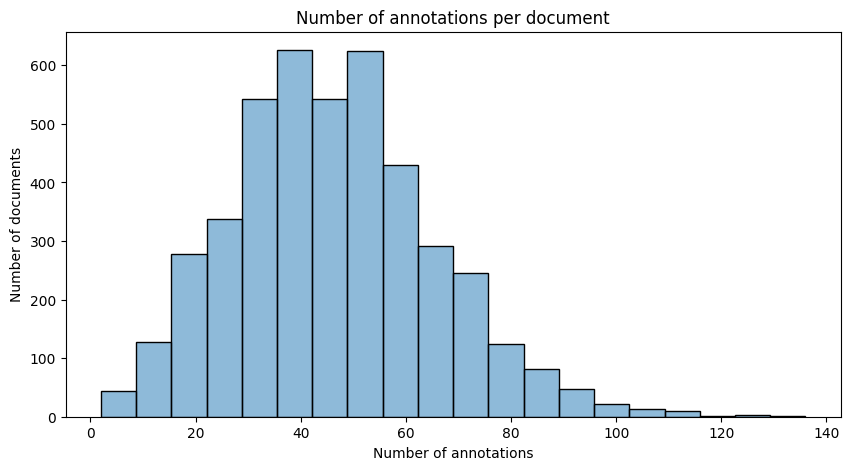

In [29]:
annots_per_documents = annotations_21.groupby('PMID').agg({'index':len})
draw_histogram(annots_per_documents,'Number of annotations per document', 'Number of annotations', 'Number of documents')

```
as topic in this case we understand unique annotation 

```

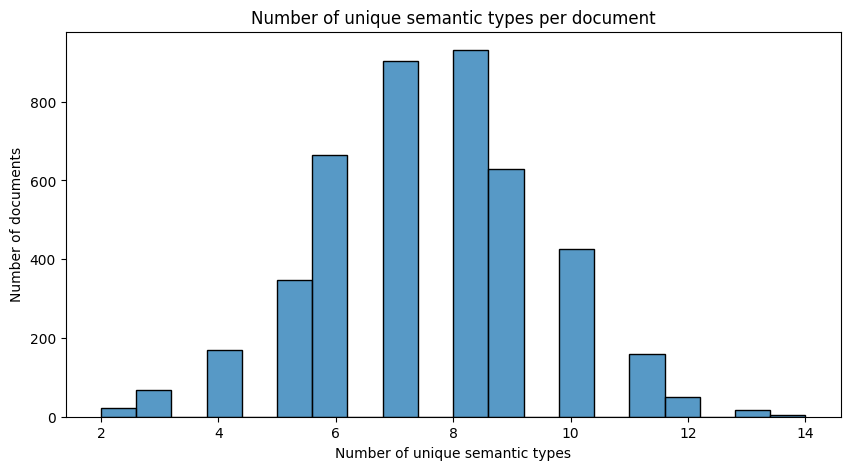

In [91]:
grouped_annotations = annotations_21.groupby('PMID')
topics_per_documents = grouped_annotations.apply(lambda x: len(set(x['SemanticMeaning'].to_list())))
draw_histogram(topics_per_documents,'Number of unique semantic types per document', 'Number of unique semantic types', 'Number of documents')

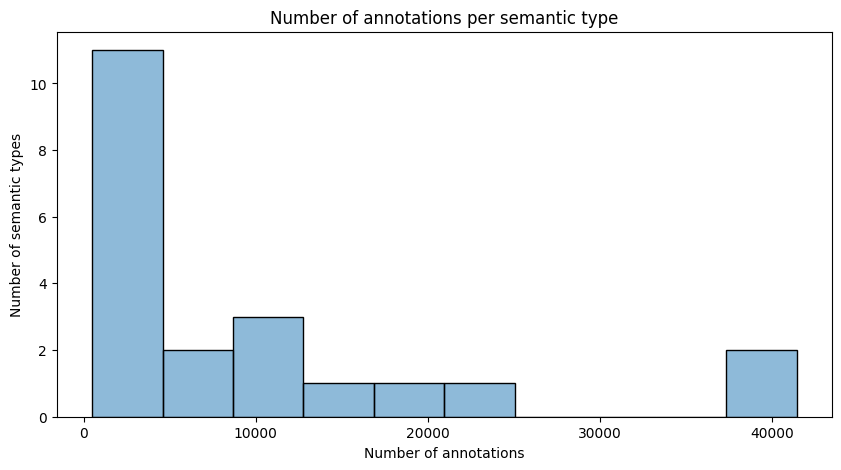

In [92]:
annots_per_sem = annotations_21.groupby('SemanticMeaning').agg(count = ('index',len))
draw_histogram(annots_per_sem,'Number of annotations per semantic type', 'Number of annotations', 'Number of semantic types', bins_number=10)

In [32]:
annots_per_sem.sort_values(by = "count", ascending=False)

,count
SemanticMeaning,
Biologic Function,41422
Chemical,37401
Health Care Activity,24306
Anatomical Structure,20497
Finding,16227
Spatial Concept,12500
Intellectual Product,10324
Research Activity,9172
Eukaryote,8543


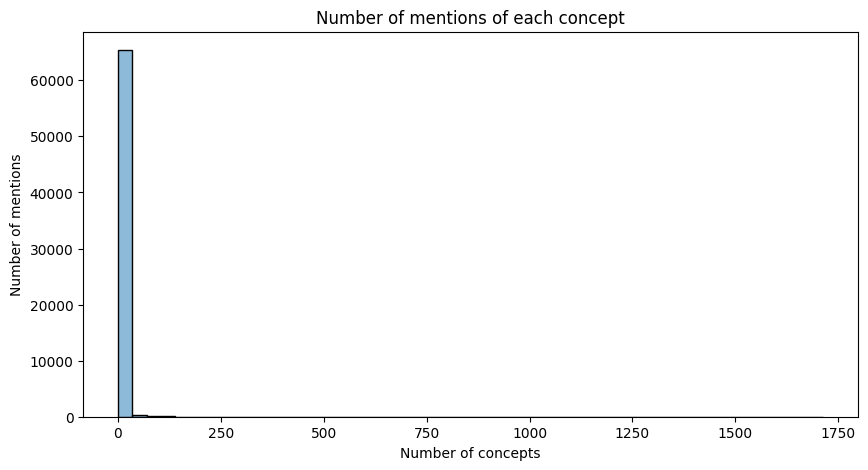

In [33]:
annots_per_type = annotations_21.groupby('MentionTextSegment').agg(count = ('index',len))
draw_histogram(annots_per_type,'Number of mentions of each concept', 'Number of concepts', 'Number of mentions', bins_number=50)

In [35]:
annots_per_type.sort_values(by = "count", ascending=False)

,count
MentionTextSegment,
study,1713
expression,799
treatment,763
women,549
human,504
...,...
arousal system,1
arousals,1
array CGH,1


# Saving raw data

In [175]:
annotations_21.to_csv(os.path.join(folder,"annotations_21_raw.csv"))
data_21.to_csv(os.path.join(folder,"titles_and_abstracts_raw.csv"))

# Data Cleaning

In [36]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

## sentences
```
divide documents into sentences
```

In [37]:
data_21['tokenized_sentences'] = data_21['Content'].apply(lambda text : nltk.sent_tokenize(text))

## words
```
tokenized_words - divide each sentence into words - result format list of lists
tokenized_words_processed - divide each sentence into words, delete stopwords and perform stemming
```

In [38]:
def process(sentence: list) -> list:
    """
    takes list of tokens and returns steamed tokens without stopwords
    If word contains non-letters it appends it to the final list
    """
    processed = []
    for word in sentence:
        try:
            word_lower = word.lower() 
            if word_lower not in stopwords.words():
                processed.append(ps.stem(word))
        except TypeError: # when word contains non-letters
            processed.append(word)
    return processed

In [ ]:
def process_lemma(sentence: list) -> list:
    """
    takes list of tokens and returns steamed tokens without stopwords
    If word contains non-letters it appends it to the final list
    """
    processed = []
    for word in sentence:
        try:
            word_lower = word.lower() 
            if word_lower not in stopwords.words():
                processed.append(lemmatizer.lemmatize(word))
        except TypeError: # when word contains non-letters
            processed.append(word)
    return processed

In [231]:

data_21['tokenized_words'] = None
data_21['tokenized_words_processed'] = None
data_21['tokenized_words_lemmatize'] = None
for index, row in tqdm(data_21.iterrows(), total = len(data_21)):
    tokens = []
    tokens_processed= []
    tokens_lemma = []
    for sentence in row['tokenized_sentences']:
        tok_sen = nltk.word_tokenize(sentence)
        tokens.append(tok_sen)
        tokens_processed.append(process(tok_sen))
        tokens_lemma.append(process_lemma(tok_sen))
    data_21.loc[index,'tokenized_words']  = tokens
    data_21.loc[index,'tokenized_words_processed']  = tokens_processed
    data_21.loc[index, 'tokenized_words_lemmatize'] = tokens_lemma
        

100%|██████████| 8784/8784 [3:04:51<00:00,  1.26s/it]     


```
delete non alpha numeric words
```

In [239]:

for index, row in tqdm(data_21.iterrows(), total = len(data_21)):
    tokens = []
    for sentence in row['tokenized_words_lemmatize']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    data_21.loc[index,'tokenized_words_lemmatize']  = tokens
            
            
        

100%|██████████| 8784/8784 [00:01<00:00, 8446.00it/s]


In [ ]:

for index, row in tqdm(data_21.iterrows(), total = len(data_21)):
    tokens = []
    for sentence in row['tokenized_words_processed']:
        sen = []
        for word in sentence:
            if word.isalnum():
                tokens.append(word)
        
    data_21.loc[index,'tokenized_words_processed']  = tokens

```
Final dataframe contains addtionaly ( comparing to the raw one ):
    - tokenized_sentences - content divided into sentences
    - tokenized_words - each sentence divide into words
    - tokenized_words_processed - content divided into words without stopwords and non-alphanumeric ones, words are stemmed

In [245]:
data_21.to_csv(os.path.join(folder,"titles_and_abstracts_processed.csv"))

# Topic per document
```
Assuming that each annotated word is a topic of the document ( it enables comparison with results from algorithms ),
the document contating PMID and list of annotations is prepered
Columns:
- Topics - list of all annotated semantics ( with repetitions )
- Unique_topics - list of all annotated semantics ( without repetitions )

```

In [79]:
grouped_annotations = annotations_21.groupby('PMID')
topics_per_document = grouped_annotations.apply(lambda group : group['SemanticMeaning'].to_list())
topics_per_document = pd.DataFrame(topics_per_document).rename(columns = {0:'Topics'})
topics_per_document['Unique_topics'] = topics_per_document['Topics'].apply(lambda l: pd.unique(l))
topics_per_document.head()

,Topics,Unique_topics
PMID,,
25763772,"[Chemical, Biologic Function, Biologic Functio...","[Chemical, Biologic Function, Finding, Researc..."
25847295,"[Biologic Function, Anatomical Structure, Find...","[Biologic Function, Anatomical Structure, Find..."
26316050,"[Chemical, Finding, Medical Device, Spatial Co...","[Chemical, Finding, Medical Device, Spatial Co..."
26406200,"[Finding, Biologic Function, Spatial Concept, ...","[Finding, Biologic Function, Spatial Concept, ..."
26424709,"[Finding, Health Care Activity, Spatial Concep...","[Finding, Health Care Activity, Spatial Concep..."


In [81]:
topics_per_document.to_csv(os.path.join(folder,'topics_per_document.csv'))

# Concepts per document
```
Columns:
- Concepts - list of all annotated concepts ( with repetitions )
- Unique_concepts - list of all annotated concepts ( without repetitions )

```


In [89]:
concepts_per_document = grouped_annotations.apply(lambda group : group['EntityID'].to_list())
concepts_per_document = pd.DataFrame(concepts_per_document).rename(columns = {0:'Concepts'})
concepts_per_document['Unique_concepts'] = concepts_per_document['Concepts'].apply(lambda l: pd.unique(l))
concepts_per_document.head()

,Concepts,Unique_concepts
PMID,,
25763772,"[UMLS:C4308010, UMLS:C0854135, UMLS:C0010674, ...","[UMLS:C4308010, UMLS:C0854135, UMLS:C0010674, ..."
25847295,"[UMLS:C0162638, UMLS:C0085262, UMLS:C0150312, ...","[UMLS:C0162638, UMLS:C0085262, UMLS:C0150312, ..."
26316050,"[UMLS:C0037114, UMLS:C2828363, UMLS:C0085104, ...","[UMLS:C0037114, UMLS:C2828363, UMLS:C0085104, ..."
26406200,"[UMLS:C0277814, UMLS:C0231452, UMLS:C0231472, ...","[UMLS:C0277814, UMLS:C0231452, UMLS:C0231472, ..."
26424709,"[UMLS:C0241311, UMLS:C0008819, UMLS:C1514578, ...","[UMLS:C0241311, UMLS:C0008819, UMLS:C1514578, ..."


In [90]:
topics_per_document.to_csv(os.path.join(folder_to_save,'concepts_per_document.csv'))

# Train, Test division
```
80 % of data are used for traing , the rest for the test
```

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
unique_pmids = data_21['PMID'].drop_duplicates()
train_pmids, test_pmids = train_test_split(unique_pmids, test_size=0.2)

In [ ]:
data_21.merge(train_pmids).to_csv(os.path.join(folder_to_save,'titles_and_abstracts_processed_train.csv', index=False))
data_21.merge(test_pmids).to_csv(os.path.join(folder_to_save,'titles_and_abstracts_processed_test.csv', index=False))